In [1]:
from warnings import filterwarnings

In [2]:
filterwarnings('ignore')

In [3]:
from copy import deepcopy
from collections import defaultdict
from pprint import pprint
import re
import string
import pandas as pd
import numpy as np
import math
from scipy import sparse

In [4]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim

In [5]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

In [6]:
import nltk
from nltk import word_tokenize 
from nltk.stem import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

In [7]:
filterwarnings('ignore')

from gensim import corpora, models, similarities, matutils
from gensim.corpora.dictionary import Dictionary

In [8]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/charlieyaris/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
# imported custom function to lemmatize and then stem individual words.
from my_functions import LemmaStemTokenizer
# imported custom function to create a dataframe
# that allows for stem/lemmatize words to be matched with the top original matching word.
from my_functions import tokenized_df_lookup
# imported custom function that takes in a vectorizer/min_df
# and returns a document term matric, a dataframe, and a vecotrizer object.
from my_functions import dtm_unigram
# imported custom function that takes in lda_docs (a distribution of topic probabilities),
# and returns a dataframe by document to reflect this probability distribution.
from my_functions import topics_df_func
# imported custom function that displays LSA topic words after matrix de-factorization.
from my_functions import display_topics
# imported custom function that renames idword dictionary
# according to the most popular word for a given lemmatize/stem transformed word.
from my_functions import id2word_rename
# imported function that uses pyLDAvis to return a visualization file.
from my_functions import pyLDAvis_plot
# imported function that rotates a given coordinate around a given origin.
from my_functions import rotate_coordinate

In [10]:
pd.set_option('display.max_columns', 100000)
# pd.set_option('display.max_colwidth', 1000)

In [11]:
df = pd.read_pickle('pickle/prophecy_df.pkl')
h2_df = pd.read_pickle('pickle/h2_df.pkl')
pre_df = pd.read_pickle('pickle/pre_df.pkl')

In [12]:
# created a second dataframe that contains Nostradamus'
# Epistle to Henry II and the prephace to Les Propheties.
df2 = pd.concat([h2_df[0], pre_df[0]], axis = 0, join = 'outer').reset_index()
df2.rename({0: 'doc'}, axis = 1, inplace = True)
df2.drop('index', axis = 1, inplace = True)

In [13]:
df2

,doc
0,TO THE MOST INVINCIBLE MOST POWERFUL AND MOST ...
1,Greetings and happiness to Cesar Nostradamus m...


In [14]:
df['century'].value_counts(normalize = True)

10.0    0.106157
9.0     0.106157
8.0     0.106157
6.0     0.106157
5.0     0.106157
4.0     0.106157
3.0     0.106157
2.0     0.106157
1.0     0.106157
7.0     0.044586
Name: century, dtype: float64

In [15]:
# removed all non-alphanumeric and punctuation characters from both dataframes.
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

df['prophecy'] = df['prophecy'].map(alphanumeric).map(punc_lower)
df2['doc'] = df2['doc'].map(alphanumeric).map(punc_lower)

In [16]:
# list of proper nouns that were considered to be included as stop words.

# 'africa', 'florence', 'france', 'geneva', 'german', 'hungary',
# 'italy', 'lusitania', 'macedonia', 'spain',
# 'tuscan', 'hundreds', 'come', 'latin', 'london', 'navarre',
# 'lorraine', 'bordeaux', 'chyren', 'armenia',
# 'barcelona', 'navarre', 'apennine', 'hesperia', 'gaul',
# 'tiber', 'neptune', 'malta', 'seine', 'loire', 'pyrenees', 'marseilles', 'orleans'

In [17]:
# created a list of stop words to add to english stop words.
stop_word_list = ['able', 'according', 'aix', 'la', 'dy', 'having', 'l', 'le',
                  'li', 'o', 's', "’", 'very', 'veri', 'like', 'sens', 'did',
                  'way', 'because', 'cause', 'half', 'hundred', 'seventy', "'", "'a",
                  "'i", "'k", "'l", "'o", "'s", ',', '[', ']']
stop_words = text.ENGLISH_STOP_WORDS.union(stop_word_list)

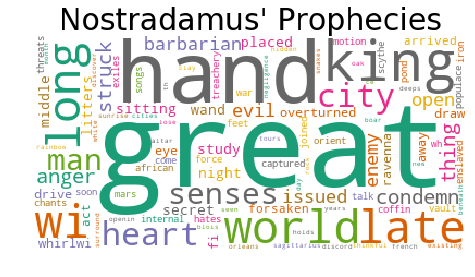

In [18]:
# created a word cloud of top words in the prophecies.
wc = WordCloud(background_color = 'white', max_words = 100, stopwords = stop_words, colormap = 'Dark2_r')
wc.generate(str(df['prophecy']))

plt.figure(figsize = (15, 4))
plt.imshow(wc)
plt.axis('off')
plt.savefig('visualizations/nostradamus_prophecies'+'.png', bbox_inches = 'tight')
plt.title("Nostradamus' Prophecies", fontsize = 30)
plt.show()
plt.close()

In [19]:
# created a tokenized list of all lemmatized/stemmed words.
# used this list as an input into tokenized_df_lookup()
# to return the most common original word as a lookup value.
lemma = WordNetLemmatizer()
stemmer = SnowballStemmer('english')

tokenized_list = []
for i in range(0, len(df['prophecy']) - 1):
    for original_word in df['prophecy'][i].split():
        word = re.sub(r"[^A-Za-z0-9\-]", " ", original_word).lower().split()
        lemma_word = [lemma.lemmatize(t, pos = 'v') for t in word_tokenize(word[0])][0]
        stem_word = [stemmer.stem(str(lemma_word))][0]
        tokenized_list.append(stem_word + ", " + original_word)
tokenized_df = tokenized_df_lookup(tokenized_list)

In [20]:
tokenized_df.to_pickle('pickle/tokenized_df.pkl')

In [21]:
tokenized_df = pd.read_pickle('pickle/tokenized_df.pkl')

#### Unigram LDA Modeling with Gensim (Count Vectorizer)

In [22]:
# used dtm_unigram to return document term matrix as a dataframe and the vectorizer as lda_model.
# tokenized words with CountVectorizer.
cv1_df = dtm_unigram(CountVectorizer, tokenized_df, df['prophecy'], stop_word_list, 4)[1]
lda_model = dtm_unigram(CountVectorizer, tokenized_df, df['prophecy'], stop_word_list, 4)[2]
print(len(cv1_df.columns))

770


In [23]:
cv1_df.to_pickle('pickle/cv1_df.pkl')

In [24]:
cv1_df = pd.read_pickle('pickle/cv1_df.pkl')

In [25]:
cv1_df.head(3)

,abandon,above,accompanied,accomplish,accuse,act,adherent,adriatic,adversary,advise,africa,african,afterwards,age,agreement,air,alas,alba,alive,allied,alps,ambush,ancient,ancona,anger,any,animal,anointed,another,apennine,appear,approach,april,aquitaine,arab,arch,aries,arise,arm,armenia,armies,array,arrive,arrow,asia,assault,assemble,attain,ausonia,author,avenge,avignon,await,away,bad,balance,band,banish,banner,barbarian,barcelona,bark,bastard,battle,bear,beard,bearer,beast,became,bed,before,believe,bell,besieged,betray,bigorre,bird,black,blame,bleed,bleedy,blois,blood,blow,bodies,bone,bordeaux,born,bound,branch,breton,bride,bridge,bright,bring,british,broken,brother,brought,brussels,burgundy,buried,burn,byzantium,cage,calamities,campania,cancer,cannon,captive,capture,carcassonne,carried,celebrate,celestial,celtic,centuries,chain,change,chartres,chase,chief,child,choked,church,chyren,cities,citizens,clergy,close,cock,cold,cologne,color,column,combat,come,commit,complain,complete,conceal,condemn,confined,conflict,confuse,conquer,consent,conspirator,contrary,convert,countries,course,cover,cries,cross,crowd,crown,cruel,custom,cut,cycle,danger,dark,daughter,day,dead,death,debated,deceive,deed,deep,defeated,defend,deliver,demand,denied,deprive,desert,desolated,despair,destroy,devastate,devour,die,discord,discover,distant,diverse,divide,divine,doe,dole,double,doubt,drag,draw,dread,dream,drive,drizzle,drought,drowned,drunk,duke,during,dust,eagle,earth,east,eastern,eat,edict,egypt,elder,elect,elevate,emperor,empire,emptied,end,enemies,english,enter,enterprise,entire,envy,equal,escape,europe,every,everyone,evil,execute,exile,expose,extend,exterminate,extinguished,eye,face,fail,faint,faith,fall,false,fame,famine,far,father,fault,favor,fear,feet,feigned,ferrara,festival,field,fierce,fight,fish,flame,flanders,fled,fleet,flesh,flies,flood,florence,flow,foix,follow,foot,force,forehead,foreign,forest,form,fort,forth,fortress,fortune,france,free,freeze,french,friend,frighten,frog,fruit,fury,gallic,garb,garonne,gate,gather,gaul,geneva,genoa,german,germany,ghent,gift,given,gnaw,god,gold,good,govern,great,green,grief,grow,guard,gulf,hail,hair,hand,happen,happiness,harbor,hard,harm,harsh,hate,head,hear,heart,heaven,heir,help,hercules,hesperia,hidden,hideous,hierarchy,high,held,holy,honey,honor,hope,horrible,horror,horse,hostage,house,howl,human,hung,hungary,hunger,hurl,ignorant,include,infinite,inhabitants,innocence,inside,instant,insult,interpret,iron,isle,island,issued,italy,join,joy,jupiter,kill,king,knew,known,ladies,laid,lake,lamentable,land,langres,language,large,late,latin,law,lead,league,learn,leave,lectoure,led,left,legion,leo,letter,liberty,lie,life,light,lightning,ligurian,line,lion,little,live,lock,lodge,loire,london,long,looking,lord,lorraine,lose,love,low,lucca,lyon,main,maintain,made,malta,man,many,mars,marble,march,marine,mark,marry,marseilles,marvel,mastiff,meaning,men,mercury,metal,middle,mighty,milan,military,milk,million,monaco,monarch,monk,monster,month,moon,mortal,mother,mount,mountain,mouth,murder,naked,naples,narbonne,nation,naval,navarre,near,nearest,need,nephew,neptune,new,nice,night,nime,noble,noise,norman,north,nose,nothing,number,obscure,occupied,ocean,offspring,oh,old,omen,open,opposite,order,orleans,outrage,outside,overcome,palace,pale,pardon,paris,parma,party,pass,passage,peace,people,perish,perpignan,persia,pestilence,phalanx,philip,piece,pierce,pike,pillage,pillar,pisa,pitiful,place,plague,plain,plot,plunder,plunge,po,point,poison,pole,pontiff,poor,port,pour,power,praise,prelate,preparations,present,press,prey,priest,prince,principal,prison,promise,promontory,prompt,proud,public,punish,pursue,pyrenees,quarrel,queen,quite,rain,raise,ravenna,ravish,read,realm,receive,red,refusal,reign,reims,relief,remain,remorse,remove,renew,renown,republic,rest,restore,return,revolt,rhine,rhodes,rhone,right,rise,river,road,rob,rochelle,rock,roman,romania,rome,rouen,rout,royal,ruin,rule,run,sacred,sacrif,sad,safe,sagittarius,sail,sa

In [26]:
counts = sparse.csr_matrix(cv1_df.values.T)
print('counts.shape:', counts.shape)
corpus = matutils.Sparse2Corpus(counts)
id2word = dict((v, k) for k, v in lda_model.vocabulary_.items())
# renamed id2word dictionary items using
# tokenized_df parameter and id2word_rename custom function.
id2word = id2word_rename(id2word, tokenized_df)
print('id2word length:', len(id2word))

counts.shape: (770, 942)
id2word length: 770


In [27]:
filterwarnings('ignore')

lda = models.LdaModel(corpus = corpus, num_topics = 3, id2word = id2word, passes = 25)
print('LDA w/ CountVectorizer Unigrams, Max_Df = 4')
lda.print_topics()

LDA w/ CountVectorizer Unigrams, Max_Df = 4


[(0,
  '0.050*"great" + 0.026*"die" + 0.016*"king" + 0.012*"time" + 0.012*"cities" + 0.011*"new" + 0.010*"seven" + 0.010*"come" + 0.009*"long" + 0.009*"change"'),
 (1,
  '0.042*"great" + 0.019*"sea" + 0.017*"land" + 0.015*"come" + 0.014*"king" + 0.011*"fleet" + 0.010*"place" + 0.010*"people" + 0.009*"bleed" + 0.008*"law"'),
 (2,
  '0.030*"great" + 0.019*"near" + 0.017*"come" + 0.013*"people" + 0.012*"die" + 0.010*"place" + 0.010*"realm" + 0.009*"bleed" + 0.009*"water" + 0.009*"long"')]

In [28]:
# created new dataframe x_topics_df using topics_df_func
# and lda_docs as the input.
lda_corpus = lda[corpus]
lda_docs = [doc for doc in lda_corpus]
x_topics_df = topics_df_func(lda_docs)

In [29]:
x_topics_df.head(3)

,0,1,2
0,0.037607,0.041562,0.920832
1,0.031161,0.031924,0.936915
2,0.554328,0.410713,0.034958


In [30]:
# created second corpus to take in extra nostradamus documents as the input,
# without changing the existing model.
counts2 = lda_model.transform(df2['doc']).T
print('counts2.shape:', counts2.shape)
corpus2 = matutils.Sparse2Corpus(counts2)

counts2.shape: (770, 2)


In [31]:
# created new dataframe y_topics_df using topics_df_func
# and lda_docs as the input.
lda_corpus = lda[corpus2]
lda_docs = [doc for doc in lda_corpus]
y_topics_df = topics_df_func(lda_docs)

In [32]:
y_topics_df

,0,1,2
0,0.452642,0.297923,0.249435
1,0.465042,0.152009,0.382948


In [33]:
# created new topics dataframes for prophecies and additional two nostradamus documents.
X_topics = pd.DataFrame(x_topics_df, index = list(np.arange(0, 942)), columns = [0, 1, 2])
y_topics = pd.DataFrame(y_topics_df, index = [0, 1], columns = [0, 1, 2])

In [34]:
# reduced 3 topic probabilities to two dimensions for plotting.
pca = PCA(n_components = 2)
X_pca = pd.DataFrame(pca.fit_transform(X_topics))
X_pca.rename({0: 'PCA1', 1: 'PCA2'}, axis = 1, inplace = True)
X_col_max = pd.DataFrame(X_topics.apply(lambda x: x.argmax(), axis = 1)).reset_index()
X_col_max.rename({0: 'Max_Topic'}, axis = 1, inplace = True)
X_pca = pd.concat([X_pca['PCA1'], X_pca['PCA2'], X_col_max['Max_Topic']], axis = 1, join = 'outer')

In [35]:
X_pca['Max_Topic'].value_counts()

0    339
1    310
2    293
Name: Max_Topic, dtype: int64

In [36]:
X_pca.to_csv('topic_cluster_coordinates/x_lda_3.csv')

In [37]:
# reduced 3 topic probabilities to two dimensions for plotting.
y_pca = pd.DataFrame(pca.transform(y_topics))
y_pca.rename({0: 'PCA1', 1: 'PCA2'}, axis = 1, inplace = True)
y_col_max = pd.DataFrame(y_topics.apply(lambda x: x.argmax(), axis = 1)).reset_index()
y_col_max.rename({0: 'Max_Topic'}, axis = 1, inplace = True)
y_pca = pd.concat([y_pca['PCA1'], y_pca['PCA2'], y_col_max['Max_Topic']], axis = 1, join = 'outer')

In [38]:
y_pca['Max_Topic'].value_counts()

0    2
Name: Max_Topic, dtype: int64

In [39]:
y_pca.to_csv('topic_cluster_coordinates/y_lda_3.csv')

In [40]:
data = pyLDAvis_plot(lda, id2word, corpus)
pyLDAvis.save_html(data, 'visualizations/pyLDAvis/index_X_lda_3.html')
data = pyLDAvis_plot(lda, id2word, corpus2)
pyLDAvis.save_html(data, 'visualizations/pyLDAvis/index_y_lda_3.html')

#### LSA Modeling with Truncated SVD

In [41]:
# used dtm_unigram to return document term matrix as a dataframe and the vectorizer as lda_model.
# tokenized words with TF-IDF.
X = dtm_unigram(TfidfVectorizer, tokenized_df, df['prophecy'], stop_word_list, 4)[0]
tfidf_df = dtm_unigram(TfidfVectorizer, tokenized_df, df['prophecy'], stop_word_list, 4)[1]
tfidf_model = dtm_unigram(TfidfVectorizer, tokenized_df, df['prophecy'], stop_word_list, 4)[2]
print(len(tfidf_df.columns))

770


In [42]:
# transformed extra Nostradamus documents using transform method from tfidf_model.
y = tfidf_model.transform(df2['doc'])

In [43]:
lsa = TruncatedSVD(3, algorithm = 'arpack')
print(lsa)

TruncatedSVD(algorithm='arpack', n_components=3, n_iter=5, random_state=None,
       tol=0.0)


In [44]:
X_lsa = lsa.fit_transform(X)
y_lsa = lsa.transform(y)
print(lsa.explained_variance_ratio_)

[0.00399329 0.00909298 0.0080661 ]


In [45]:
print('LSA w/ TFIDF Unigrams, Max_Df = 4')
display_topics(lsa, list(tfidf_df.columns), 20)

LSA w/ TFIDF Unigrams, Max_Df = 4

Topic  0
great, die, come, king, land, near, bleed, sea, people, long, cities, time, place, new, war, capture, change, armies, realm, far

Topic  1
die, king, time, bleed, long, realm, year, capture, seven, life, conspirator, law, son, hand, wife, wounded, light, soon, tyranny, cruel

Topic  2
land, die, sea, bleed, fleet, near, water, sudden, far, tremble, war, enemies, mountain, barbarian, realm, swim, safe, town, given, fish


In [46]:
pd.DataFrame(X_lsa, index = list(np.arange(1, 943)), columns = ['topic_0', 'topic_1', 'topic_3']).head()

,topic_0,topic_1,topic_3
1,0.130430,-0.011039,-0.047239
2,0.117155,-0.018296,0.034648
3,0.156412,0.033373,-0.085372
4,0.224262,0.047632,-0.123819
5,0.150106,-0.008243,-0.019147


In [47]:
pd.DataFrame(y_lsa.round(5), index = [0, 1], columns = ['topic_0', 'topic_1', 'topic_3'])

,topic_0,topic_1,topic_3
0,0.57269,0.11032,-0.15995
1,0.31601,0.08322,-0.03469


In [48]:
# created new topics dataframes for prophecies and additional two nostradamus documents.
X_topics = pd.DataFrame(X_lsa, index = list(np.arange(1, 943)), columns = [0, 1, 2])
y_topics = pd.DataFrame(y_lsa, index = [0, 1], columns = [0, 1, 2])

In [49]:
# reduced 3 topic probabilities to two dimensions for plotting.
pca = PCA(n_components = 2)
X_pca = pd.DataFrame(pca.fit_transform(X_topics))
X_pca.rename({0: 'PCA1', 1: 'PCA2'}, axis = 1, inplace = True)
X_col_max = pd.DataFrame(X_topics.apply(lambda x: x.argmax(), axis = 1)).reset_index()
X_col_max.rename({0: 'Max_Topic'}, axis = 1, inplace = True)
X_pca = pd.concat([X_pca['PCA1'], X_pca['PCA2'], X_col_max['Max_Topic']], axis = 1, join = 'outer')

In [50]:
X_pca['Max_Topic'].value_counts()

0    854
1     54
2     34
Name: Max_Topic, dtype: int64

In [51]:
# rotated PCA1 and PCA2 45 degrees around origin
# after seeing this would better convey clusters on graph.
origin = (0, 0)
for i, coordinate in enumerate(zip(X_pca['PCA1'], X_pca['PCA2'])):
    X_pca.loc[i, 'PCA1_adj'] = rotate_coordinate(origin, coordinate, 45)[0]
    X_pca.loc[i, 'PCA2_adj'] = rotate_coordinate(origin, coordinate, 45)[1]

In [52]:
X_pca.to_csv('topic_cluster_coordinates/x_lsa_3.csv')

In [53]:
# reduced 3 topic probabilities to two dimensions for plotting.
y_pca = pd.DataFrame(pca.transform(y_topics))
y_pca.rename({0: 'PCA1', 1: 'PCA2'}, axis = 1, inplace = True)
y_col_max = pd.DataFrame(y_topics.apply(lambda x: x.argmax(), axis = 1)).reset_index()
y_col_max.rename({0: 'Max_Topic'}, axis = 1, inplace = True)
y_pca = pd.concat([y_pca['PCA1'], y_pca['PCA2'], y_col_max['Max_Topic']], axis = 1, join = 'outer')

In [54]:
y_pca['Max_Topic'].value_counts()

0    2
Name: Max_Topic, dtype: int64

In [55]:
y_pca

,PCA1,PCA2,Max_Topic
0,0.105147,-0.105641,0
1,0.080752,-0.011045,0


In [56]:
# rotated PCA1 and PCA2 45 degrees around origin
# after seeing this would better convey clusters on graph.
origin = (0, 0)
for i, coordinate in enumerate(zip(y_pca['PCA1'], y_pca['PCA2'])):
    y_pca.loc[i, 'PCA1_adj'] = rotate_coordinate(origin, coordinate, 45)[0]
    y_pca.loc[i, 'PCA2_adj'] = rotate_coordinate(origin, coordinate, 45)[1]

In [57]:
y_pca.to_csv('topic_cluster_coordinates/y_lsa_3.csv')

In [58]:
y_pca

,PCA1,PCA2,Max_Topic,PCA1_adj,PCA2_adj
0,0.105147,-0.105641,0,0.145127,0.033975
1,0.080752,-0.011045,0,0.051819,0.062910


#### NMF

In [59]:
nmf_model = NMF(n_components = 3)
X_nmf = nmf_model.fit_transform(X)
y_nmf = nmf_model.transform(y)

In [60]:
X_nmf.shape

(942, 3)

In [61]:
for i in range(3):
    print(f"Topic {i}")
    pprint(sorted(list(zip(tfidf_df.columns, nmf_model.components_[i][1:])), key = lambda line: line[1], reverse=True)[:10])
    print('\n')

Topic 0
[('govern', 1.3691109671122137),
 ('combat', 0.6123286135933874),
 ('kill', 0.6096388155878784),
 ('peace', 0.36008771466597356),
 ('chyren', 0.3301274911954874),
 ('neptune', 0.2955309113020002),
 ('chain', 0.2416588618536219),
 ('navarre', 0.24049934214544288),
 ('set', 0.19055627039429945),
 ('london', 0.18271867910666809)]


Topic 1
[('devour', 1.3461720190927104),
 ('blame', 0.4292153641948889),
 ('tiber', 0.3110838505919946),
 ('read', 0.25271951966650846),
 ('london', 0.25023555863657493),
 ('captive', 0.18049057098313273),
 ('consent', 0.125104681899841),
 ('worse', 0.12054037628650138),
 ('famine', 0.11983623850890612),
 ('soldiers', 0.11584914789512009)]


Topic 2
[('lamentable', 0.9454750572420375),
 ('scepter', 0.8174948818148199),
 ('navarre', 0.35812339210704086),
 ('pitiful', 0.25811796536063136),
 ('tree', 0.25116395168599415),
 ('want', 0.23989461931135686),
 ('mount', 0.23506171281986185),
 ('fled', 0.22518026224376367),
 ('armenia', 0.2130540270631183),
 ('pa

In [62]:
X_topics = pd.DataFrame(X_nmf, index = list(np.arange(1, 943)), columns = [0, 1, 2])
y_topics = pd.DataFrame(y_nmf, index = [0, 1], columns = [0, 1, 2])

In [63]:
# reduced 3 topic probabilities to two dimensions for plotting.
pca = PCA(n_components = 2)
X_pca = pd.DataFrame(pca.fit_transform(X_topics))
X_pca.rename({0: 'PCA1', 2: 'PCA2'}, axis = 1, inplace = True)
X_col_max = pd.DataFrame(X_topics.apply(lambda x: x.argmax(), axis = 1)).reset_index()
X_col_max.rename({0: 'Max_Topic'}, axis = 1, inplace = True)
X_pca = pd.concat([X_pca['PCA1'], X_pca['PCA1'], X_col_max['Max_Topic']], axis = 1, join = 'outer')

In [64]:
X_pca['Max_Topic'].value_counts()

0    485
2    249
1    208
Name: Max_Topic, dtype: int64

In [65]:
# reduced 3 topic probabilities to two dimensions for plotting.
y_pca = pd.DataFrame(pca.transform(y_topics))
y_pca.rename({0: 'PCA1', 2: 'PCA2'}, axis = 1, inplace = True)
y_col_max = pd.DataFrame(y_topics.apply(lambda x: x.argmax(), axis = 1)).reset_index()
y_col_max.rename({0: 'Max_Topic'}, axis = 1, inplace = True)
y_pca = pd.concat([y_pca['PCA1'], y_pca['PCA1'], y_col_max['Max_Topic']], axis = 1, join = 'outer')

In [66]:
y_pca['Max_Topic'].value_counts()

0    2
Name: Max_Topic, dtype: int64